### 1. Import packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sp
import sklearn as sk

import sklearn.metrics as metrics
import os
import pickle
import itertools  

from matplotlib import rc
from matplotlib import pyplot
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
import plotly.express as px
from statsmodels.stats.multitest import multipletests
import scipy.stats as stats
#import statsmodels.api as sm
from statsmodels.formula.api import ols
import random

In [3]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay

In [4]:
from sklearn.metrics import matthews_corrcoef

In [5]:
from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from collections import defaultdict

In [6]:
# Set the global font to be DejaVu Sans, size 10 
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})
rc('mathtext',**{'default':'regular'})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 2. Load pickles

In [7]:
#load pickles
with open(r'/Users/momenzadeha/Documents/aneurysm_study/sigprec_bcorr.pkl', 'rb') as handle:
    sig_prec_bcorr = pickle.load(handle)
with open(r'/Users/momenzadeha/Documents/aneurysm_study/sigprot_bcorr.pkl', 'rb') as handle:
    sig_prot_bcorr = pickle.load(handle)
with open(r'/Users/momenzadeha/Documents/aneurysm_study/prec_bcorr.pkl', 'rb') as handle:
    prec_bcorr = pickle.load(handle)
with open(r'/Users/momenzadeha/Documents/aneurysm_study/prot_bcorr.pkl', 'rb') as handle:
    prot_bcorr = pickle.load(handle)
with open(r'/Users/momenzadeha/Documents/aneurysm_study/prec_2_gr.pkl', 'rb') as handle:
    prec_2_gr = pickle.load(handle)
with open(r'/Users/momenzadeha/Documents/aneurysm_study/meta_prot.pkl', 'rb') as handle:
    meta_prot = pickle.load(handle)

### 3. Find top 52 PI scores

In [9]:
# disease groups 0,1,4 => 0
# control group 2,3 => 1

In [10]:
Xtrain, Xtest, ytrain, ytest = train_test_split(prot_bcorr, prec_2_gr.Group, 
                                                    random_state=42, test_size=0.2,
                                                    stratify=prec_2_gr.Group) 

In [11]:
prot_bcorr.shape

(202, 195)

In [12]:
Xtrain.shape

(161, 195)

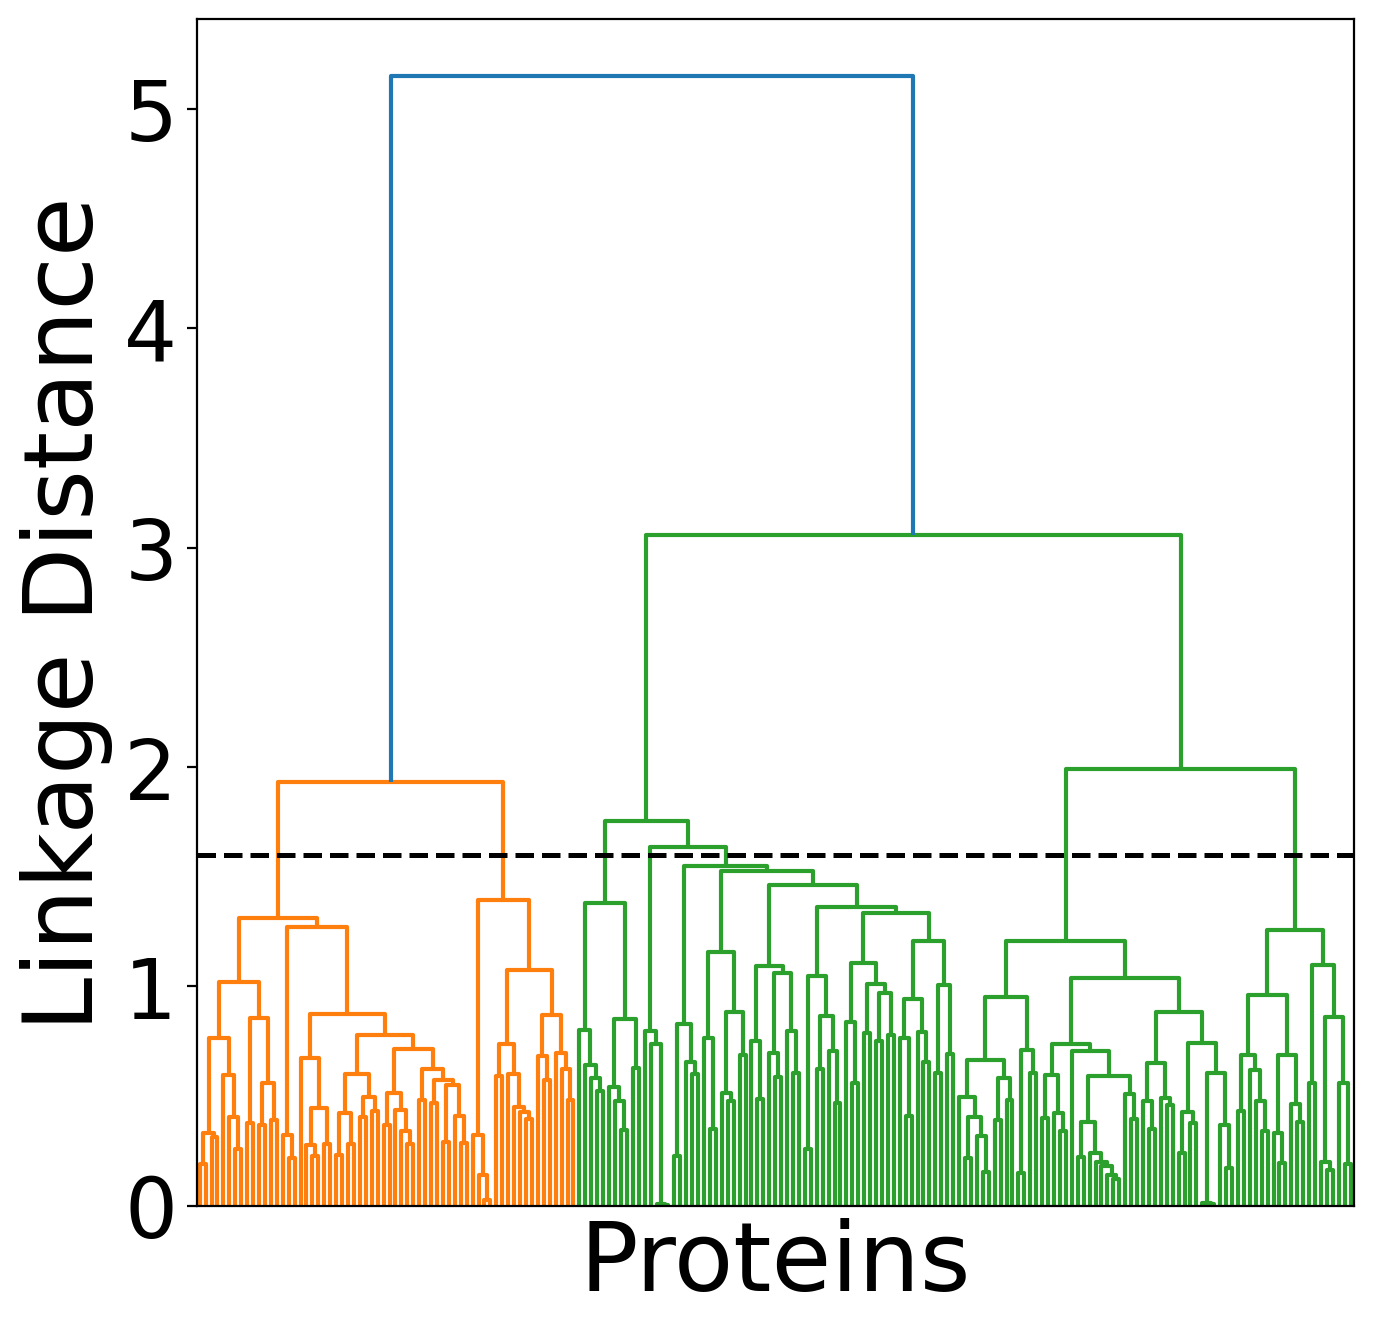

In [13]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 7))

corr = spearmanr(Xtrain).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, ax=ax1, leaf_rotation=90
)
plt.yticks(fontsize=30)
plt.xlabel('Proteins', fontsize=35)
plt.ylabel('Linkage Distance', fontsize=35)
fig.tight_layout()
plt.xticks([])

pyplot.plot([0,2000], [1.6,1.6], linestyle='--', linewidth=1.8, color='black',
            label='Selected threshold')
#plt.savefig('Fig3B.svg',bbox_inches='tight')

In [14]:
corr[dendro["leaves"], :][:, dendro["leaves"]].shape

(195, 195)

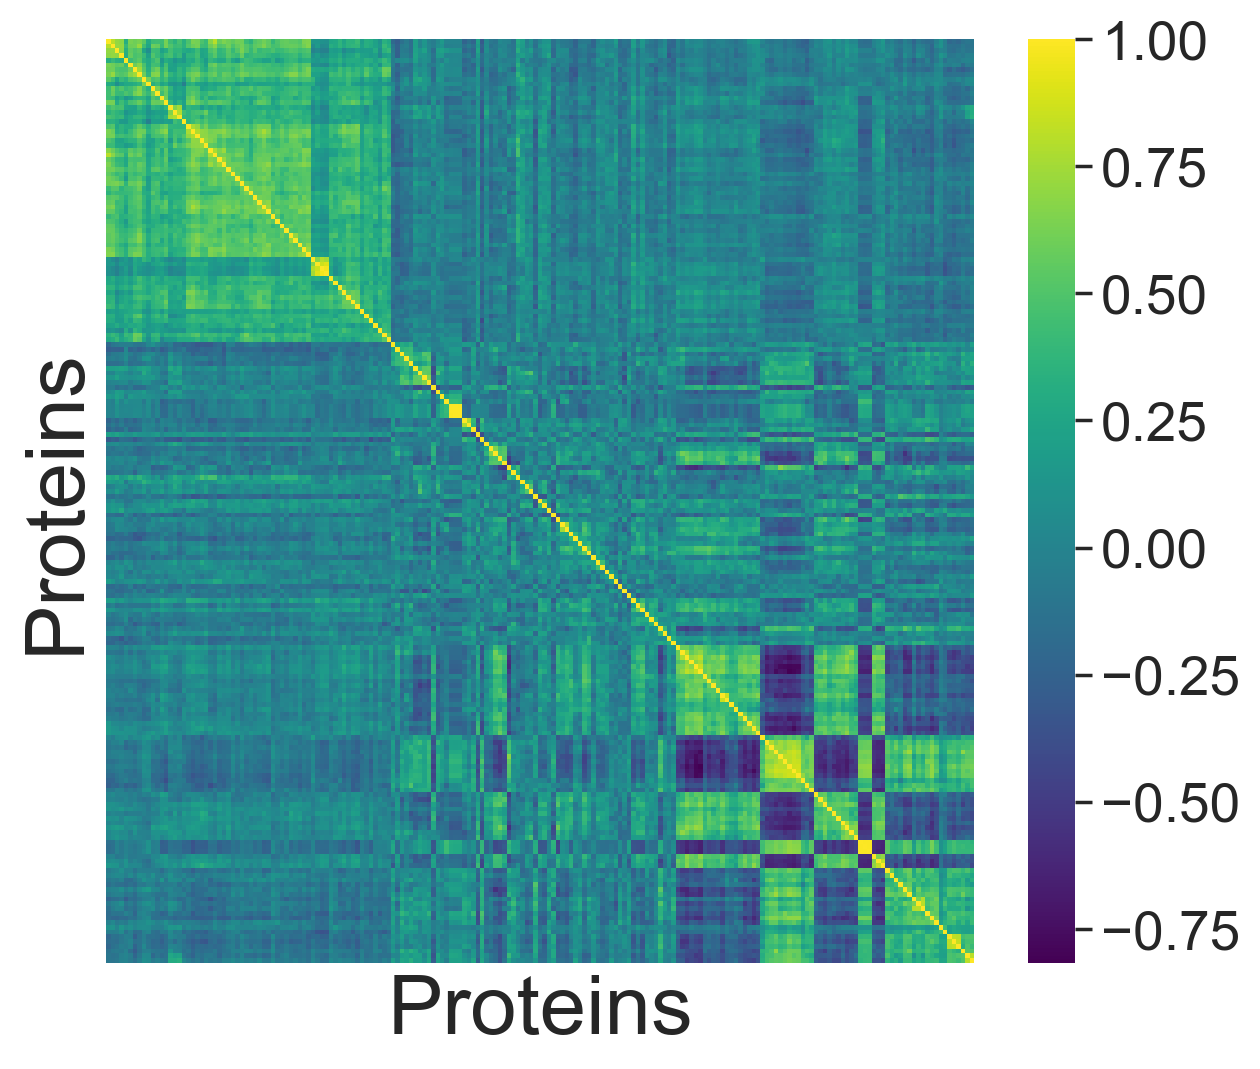

In [15]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(7,6)},font_scale=1.8)
ax=sns.heatmap(corr[dendro["leaves"], :][:, dendro["leaves"]],cmap='viridis',yticklabels=False, xticklabels=False)
pyplot.xlabel('Proteins', fontsize=30)
pyplot.ylabel('Proteins', fontsize=30)
#plt.savefig('Fig3A.svg',bbox_inches='tight')
plt.show()

In [16]:
np.arange(0,5,0.5)

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5])

In [17]:
def get_sel_features(input_df, output_df, threshold):
    corr = spearmanr(input_df).correlation
    corr = (corr + corr.T) / 2
    np.fill_diagonal(corr, 1)
    distance_matrix = 1 - np.abs(corr)
    dist_linkage = hierarchy.ward(squareform(distance_matrix))
    dendro = hierarchy.dendrogram(
    dist_linkage, labels=input_df.columns.tolist(), ax=ax1, leaf_rotation=90)

    #Xtrain, Xtest, ytrain, ytest = train_test_split(input_df, output_df, 
                                                    #random_state=42, test_size=0.2,
                                                    #stratify=output_df) 
    cluster_ids = hierarchy.fcluster(dist_linkage, threshold, criterion="distance")
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
    Xtrain_sel = input_df.iloc[:, selected_features]
    return Xtrain_sel

In [19]:
for i in np.arange(0.5,2,0.1):
    print(i)
    print(len(get_sel_features(Xtrain,prec_2_gr.Group,i).columns))

0.5
108
0.6
87
0.7
64
0.7999999999999999
45
0.8999999999999999
34
0.9999999999999999
30
1.0999999999999999
21
1.1999999999999997
19
1.2999999999999998
15
1.4
10
1.4999999999999998
9
1.5999999999999996
7
1.6999999999999997
6
1.7999999999999998
5
1.8999999999999997
5


In [ ]:
#hyperparameter optimization on training set
    
#parameters
Dummy_params = {}

GB_params = {
    'learning_rate': [0.1, 0.5, 1],
    'max_depth': [5,50,100],
    'n_estimators':[10,100,500],
    'max_features':['sqrt','log2'],
    'min_samples_leaf': [2, 20, 80, 200, 300],
    'min_samples_split': [2, 20, 80, 200, 300]}

SVC_params = {
    'C': [0.1,1,10,100],
    'kernel':['poly', 'rbf', 'sigmoid'],
    'gamma':[1,0.1,0.01,0.001]}

LR_params = {
    'C':[0.01,0.1,1,10,100],
    'penalty':['l2'],
    'solver':['newton-cg'],
    'max_iter':[100,200,300]}

ET_params = {
    'bootstrap': [True, False],
    'max_depth': [5,50,100],
    'n_estimators':[10,100,500],
    'max_features':['sqrt','log2'],
    'min_samples_leaf': [2, 20, 80, 200, 300],
    'min_samples_split': [2, 20, 80, 200, 300]}

RF_params = {
    'bootstrap': [True, False],
    'max_depth': [5,50,100],
    'n_estimators':[10,100,500],
    'max_features':['sqrt','log2'],
    'min_samples_leaf': [2, 20, 80, 200, 300],
    'min_samples_split': [2, 20, 80, 200, 300]}
           
KNN_params = {
    'leaf_size': [1,5,10,15,20,25,30,35,40,45,50],
    'n_neighbors': [1,5,10,15,20,25,30],
    'p': [1,2]}
    
models_dict = {
    'Dummy': DummyClassifier(random_state=42),
    'GB': GradientBoostingClassifier(random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'LR': LogisticRegression(random_state=42),
    'ET': ExtraTreesClassifier(random_state=42),
    'RF': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier()}

params_dict = {
    'Dummy': Dummy_params,
    'GB':GB_params,
    'SVC':SVC_params,
    'LR':LR_params,
    'ET': ET_params,
    'RF': RF_params,
    'KNN': KNN_params}

#run randomsearch
all_model_dict = {}
all_F1_dict = {}
all_AUPR_dict = {}

for i in np.arange(0.5,2,0.1):
    print('Input:', i)
    temp_1 = {}
    temp_2 = {}
    temp_3 = {}
    Xtrain_sel = get_sel_features(Xtrain,prec_2_gr.Group,i)
    for x in models_dict.keys():
        print(x)
        clf = RandomizedSearchCV(models_dict[x], param_distributions = params_dict[x],
                                 scoring='f1', refit=True, cv=5, n_iter=100, random_state=42)
        clf.fit(Xtrain_sel, ytrain)
        y_predict_proba = clf.predict_proba(Xtrain_sel)[:,1]
        precision, recall, thresholds = precision_recall_curve(ytrain,y_predict_proba)
        print('Best AUPR:',auc(recall, precision))
        print('Best F1:',clf.best_score_)
        print('Best estimator:',clf.best_estimator_)
        temp_1[x] = clf.best_estimator_
        temp_2[x] = clf.best_score_
        temp_3[x] = auc(recall, precision)
    all_model_dict[i] = temp_1
    all_F1_dict[i] = temp_2
    all_AUPR_dict[i] = temp_3
    
all_F1_df=pd.DataFrame.from_dict(all_F1_dict)
all_AUPR_df=pd.DataFrame.from_dict(all_AUPR_dict)

In [21]:
all_F1_df

,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9
Dummy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
GB,0.892865,0.921569,0.924804,0.907865,0.909566,0.901886,0.864426,0.854937,0.872569,0.900579,0.875088,0.888814,0.591454,0.533120,0.533120
SVC,0.940915,0.936134,0.912344,0.914752,0.912344,0.912344,0.879457,0.886648,0.882996,0.865023,0.879457,0.892627,0.609524,0.565965,0.565965
LR,0.940915,0.931558,0.912442,0.906331,0.888748,0.867764,0.846712,0.846712,0.884304,0.860306,0.890961,0.890961,0.536892,0.484085,0.484085
ET,0.861941,0.881331,0.917081,0.832228,0.876516,0.794444,0.827692,0.833510,0.860275,0.836647,0.863053,0.849719,0.405641,0.383361,0.383361
RF,0.885873,0.883934,0.896331,0.879762,0.828696,0.875817,0.813785,0.816367,0.868291,0.870635,0.870635,0.853053,0.605098,0.459869,0.459869
KNN,0.940915,0.951373,0.951373,0.952680,0.943323,0.939346,0.907767,0.891228,0.875579,0.887246,0.887246,0.887246,0.463077,0.438265,0.438265


In [24]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(7,6)})

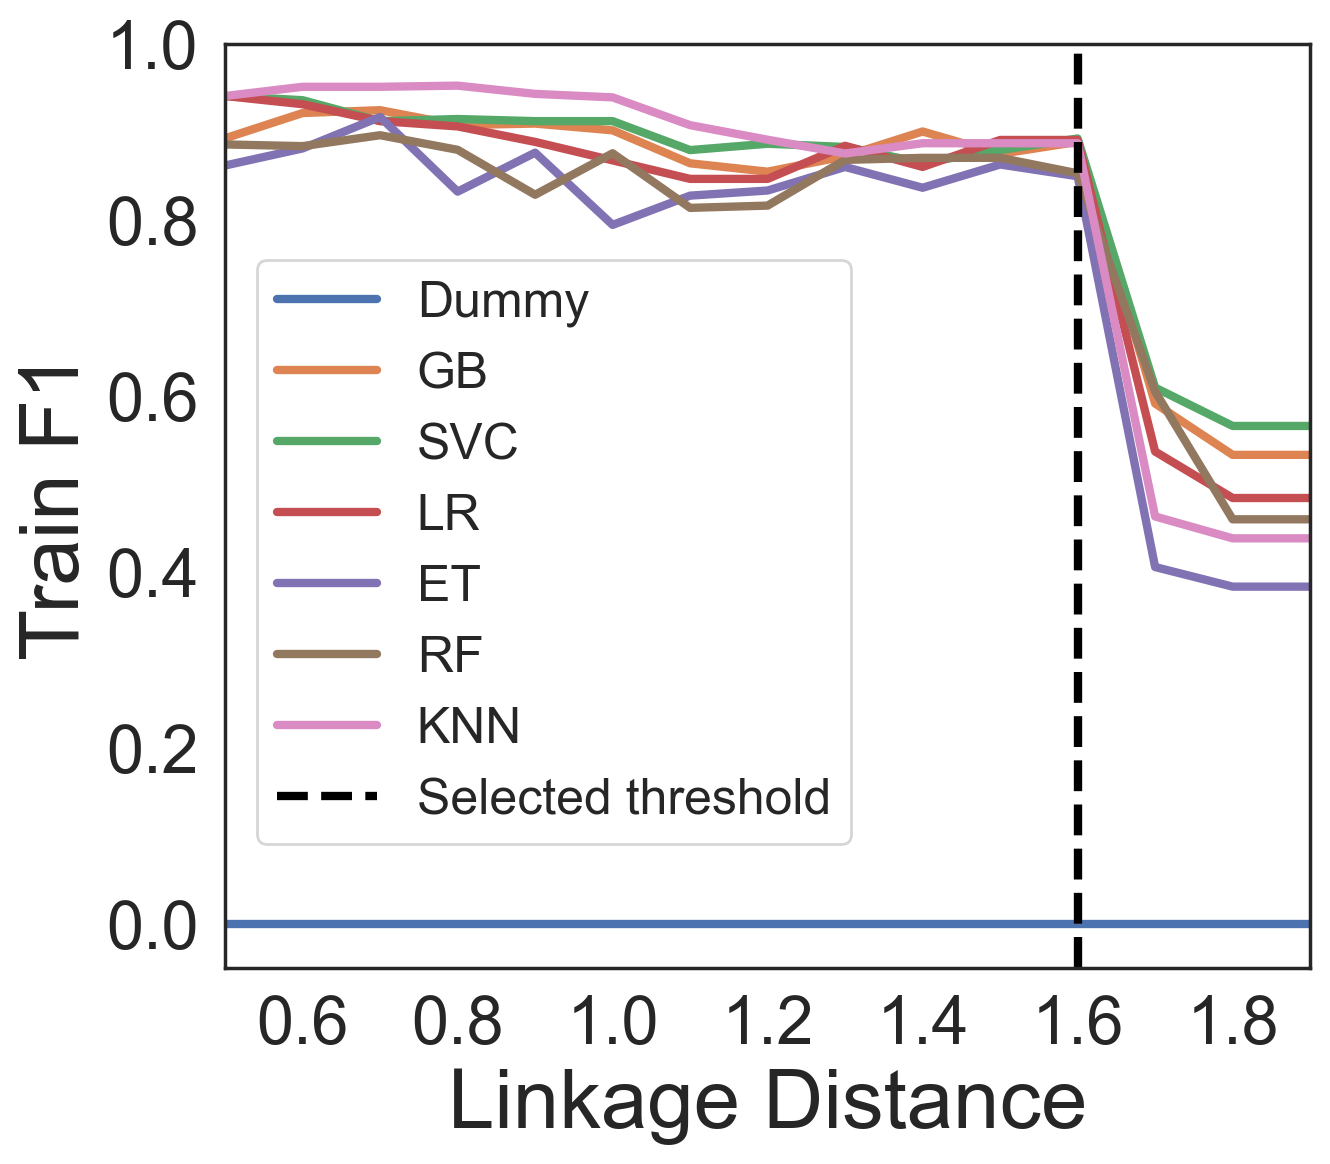

In [25]:
sns.lineplot(data=all_F1_df.T.reset_index().melt(id_vars='index'), x='index', y='value', hue='variable', linewidth=3)
#threshold line
t=1.6
pyplot.plot([t,t], [-0.1,1], linestyle='--', linewidth=3, color='black',
            label='Selected threshold')
pyplot.xlabel('Linkage Distance', fontsize=30)
pyplot.ylabel('Train F1', fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlim([0.5, 1.9])
plt.ylim([-0.05, 1.0])

leg=pyplot.legend(fontsize=18, loc='right', bbox_to_anchor=(0.6, 0.45))
leg.get_lines()[0].set_linewidth(3)
leg.get_lines()[1].set_linewidth(3)
leg.get_lines()[2].set_linewidth(3)
leg.get_lines()[3].set_linewidth(3)
leg.get_lines()[4].set_linewidth(3)
leg.get_lines()[5].set_linewidth(3)
leg.get_lines()[6].set_linewidth(3)
#plt.savefig('Fig3C.svg',bbox_inches='tight')
pyplot.show()

In [27]:
#evaluate test set based on the best part of that line
f1 = {}
AUPR = {}
threshold = 1.5999999999999996
model = all_model_dict[threshold]['SVC']
sel_feat_lst = get_sel_features(Xtrain,prec_2_gr.Group, threshold).columns.to_list()
Xtest_sel = Xtest[sel_feat_lst]
print('Xtest_sel shape:',Xtest_sel.shape)

ypred = model.predict(Xtest_sel)
probs = model.predict_proba(Xtest_sel)
pos_probs = probs[:, 1]
F1 = f1_score(ytest, ypred)  
precision, recall, _ = precision_recall_curve(ytest, pos_probs)
AUPR = auc(recall, precision)
print('F1:',F1)
print('AUPR:',AUPR)

Xtest_sel shape: (41, 7)
F1: 0.7826086956521738
AUPR: 0.898485746279864


In [28]:
Xtrain_sel = get_sel_features(Xtrain,prec_2_gr.Group,threshold)
Xtrain_sel.shape

(161, 7)

In [29]:
ytrain.value_counts()

0    120
1     41
Name: Group, dtype: int64

In [30]:
ytest.value_counts()

0    30
1    11
Name: Group, dtype: int64

In [31]:
model

SVC(C=100, gamma=0.01, probability=True, random_state=42)

In [32]:
print(f"SVC test accuracy: {model.score(Xtest_sel, ytest):.3f}")

SVC test accuracy: 0.878


In [33]:
print(f"SVC train accuracy: {model.score(Xtrain_sel, ytrain):.3f}")

SVC train accuracy: 0.963


In [34]:
prot = pd.read_csv(r'C:\\Users\\momenzadeha\\Documents\aneurysm_study\LeonFine_ProteinLevel_GFlibrary_DIANN.csv',low_memory=False) 

In [36]:
result = permutation_importance(model, Xtest_sel, ytest, n_repeats=10, random_state=42)
sorted_importances_idx = result.importances_mean.argsort()

In [40]:
genes=[]
for x in Xtest_sel.columns[sorted_importances_idx].to_list():
    genes+=prot[x].iloc[[2]].to_list()

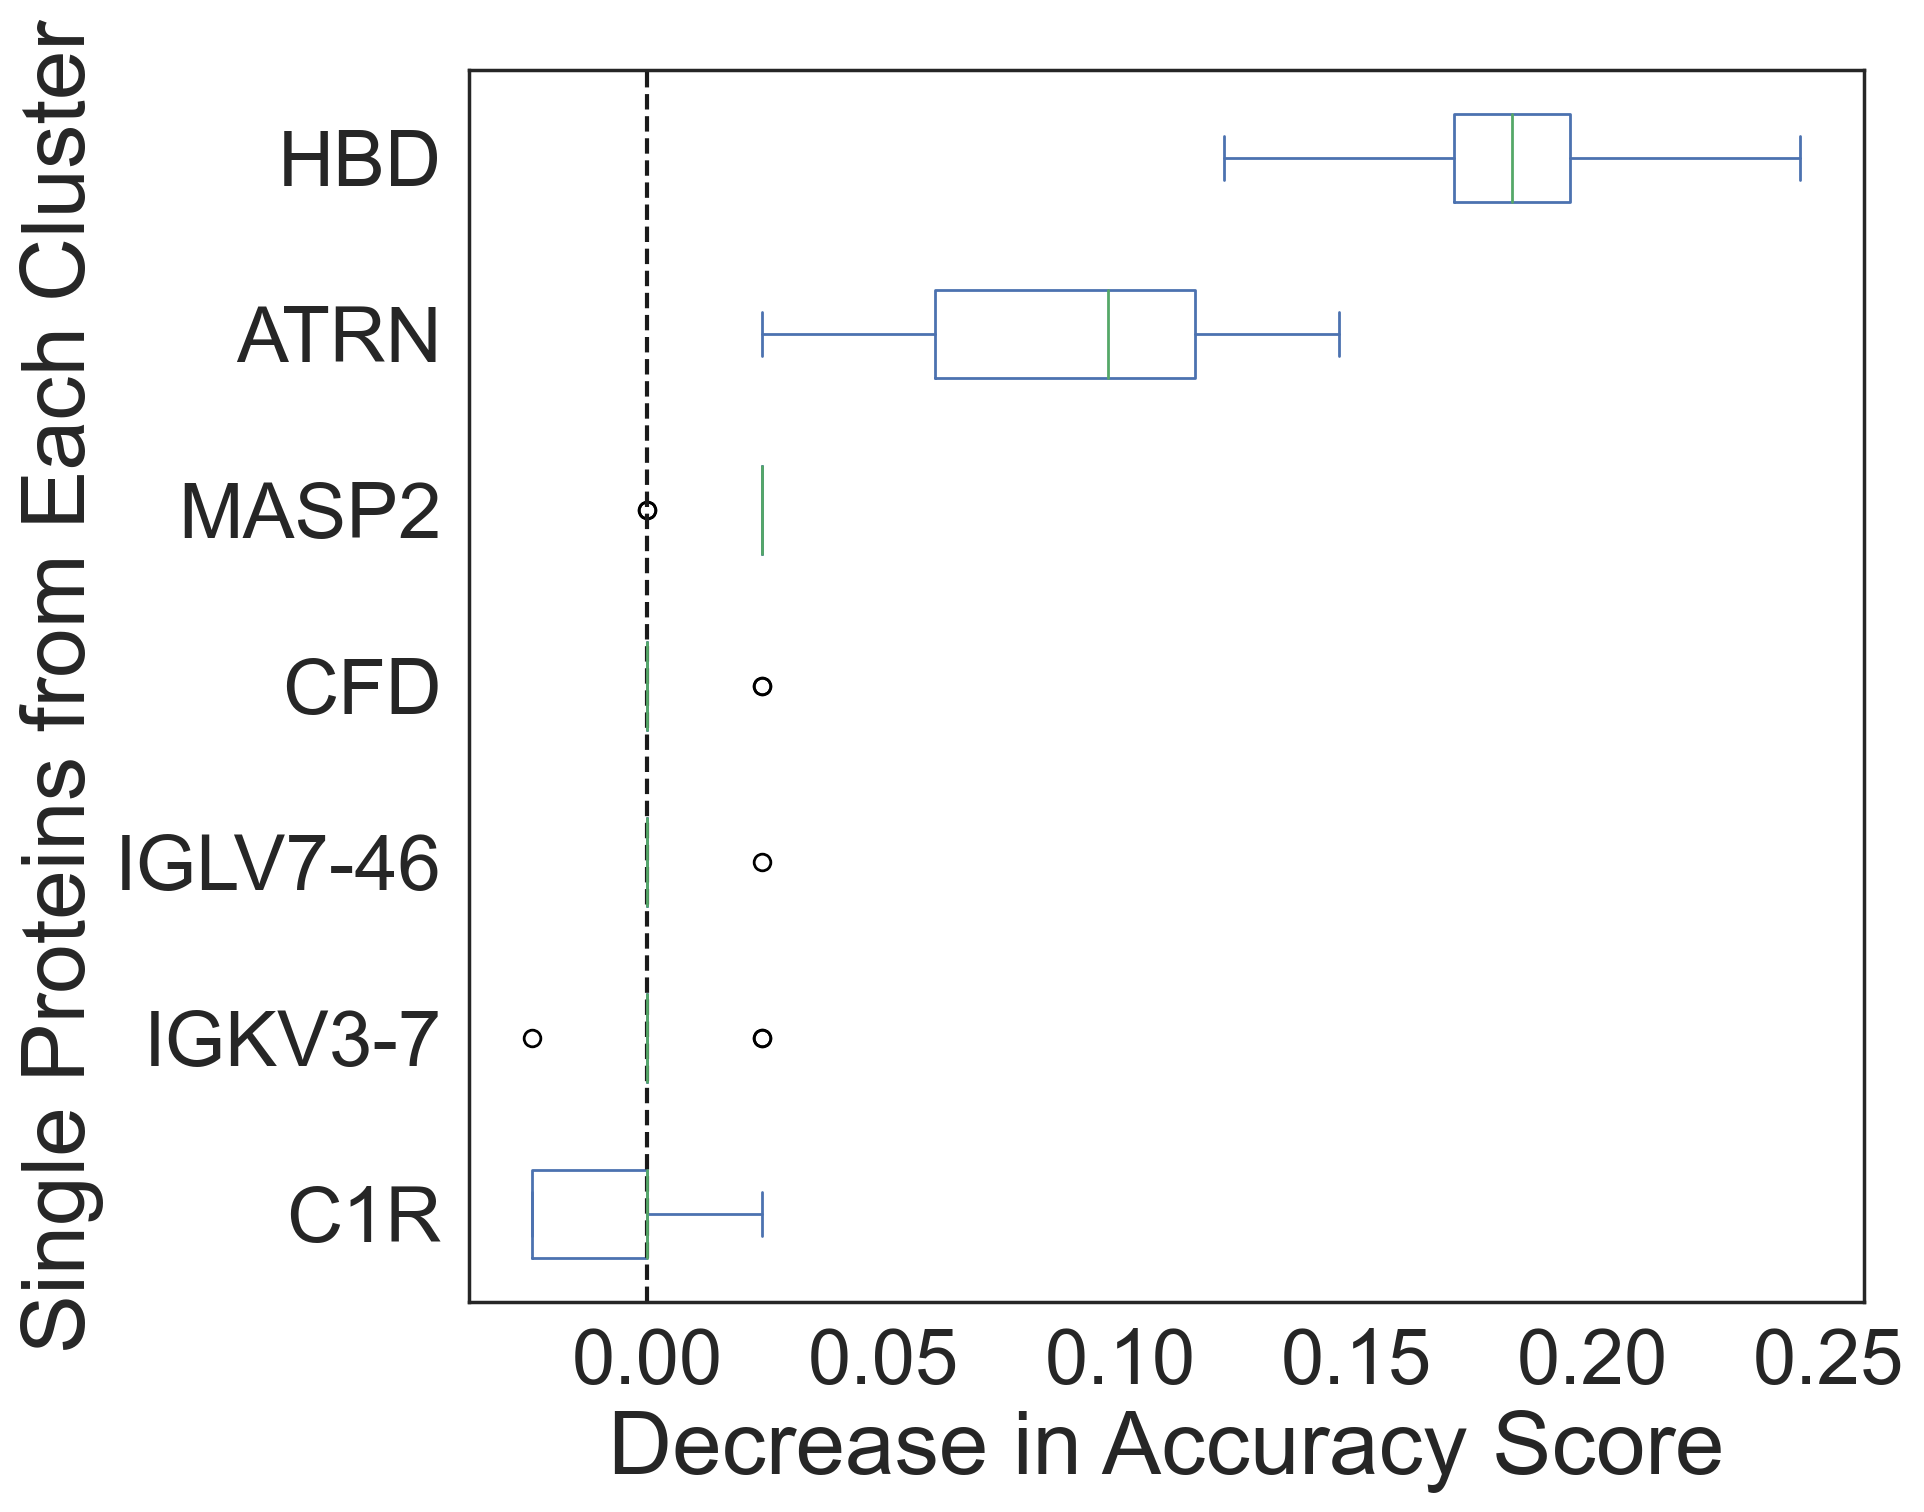

In [42]:
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=genes,
)
ax = importances.plot.box(vert=False, whis=10)
#ax.set_title("Permutation Importances (Test Set)", fontsize=30)
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in Accuracy Score", fontsize=32)
ax.set_ylabel("Single Proteins from Each Cluster", fontsize=32)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
#ax.figure.tight_layout()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 8)
#plt.savefig('Fig3D.svg',bbox_inches='tight')

In [46]:
corr = spearmanr(Xtrain).correlation
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
dist_linkage, labels=prot_bcorr.columns.tolist(), ax=ax1, leaf_rotation=90)

In [47]:
cluster_ids = hierarchy.fcluster(dist_linkage, 1.6, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
Xtrain_sel = Xtrain.iloc[:, selected_features]

In [54]:
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T, 
    columns=Xtest_sel.columns[sorted_importances_idx].to_list()
)
permutation_order_proteinID = importances[importances.columns[::-1]].columns.tolist()

In [55]:
mean_importances = importances.mean()[::-1]
mean_importances

P02042        0.182927
O75882        0.090244
O00187        0.019512
P00746        0.004878
A0A075B6I9    0.002439
A0A075B6H7    0.002439
P00736       -0.004878
dtype: float64

In [56]:
mean_importances.to_excel("importances_disease_vs_control.xlsx")  

In [58]:
#make the table
proteins_table_list = []
cluster_numbers = []
importances_table_list = []
cluster_rep= []
ordered_cluster_number = []
for key in cluster_id_to_feature_ids.keys():
    proteins_to_add = prot_bcorr.columns[cluster_id_to_feature_ids[key]].tolist()
    proteins_table_list+=proteins_to_add
    importances_table_list+=mean_importances[[proteins_to_add[0]]].tolist()*len(proteins_to_add)
    cluster_numbers+= [key]*len(proteins_to_add)
    #cluster_rep+=proteins_to_add*len(proteins_to_add)
    ordered_cluster_number += np.where(mean_importances.index==proteins_to_add[0])[0].tolist()*len(proteins_to_add)
    cluster_rep+=mean_importances[[proteins_to_add[0]]].index.tolist()*len(proteins_to_add)

IndexError: list index out of range

In [59]:
ordered_cluster_number=[x+1 for x in ordered_cluster_number]

In [60]:
SuppT1 = pd.DataFrame({'Ordered Cluster Number':ordered_cluster_number, 'Representative Cluster Protein':cluster_rep,
                   'Protein Group (Uniprot)':proteins_table_list, 'Cluster Number':cluster_numbers, 
                   'Mean Decrease in Accuracy (from Permutation Importance)':importances_table_list})

In [61]:
pr_gr=[]
genes=[]
prot_name=[]

for x in SuppT1['Protein Group (Uniprot)']:
    pr_gr+=[x]
    genes+=prot[x].iloc[[2]].to_list()
    prot_name+=prot[x].iloc[[1]].to_list()

In [62]:
SuppT1['Gene Name'] = genes

In [63]:
SuppT1['Protein Name'] = prot_name

In [65]:
SuppT1.to_excel("SuppT1_v2.xlsx")  

In [66]:
with open(r'/Users/momenzadeha/Documents/aneurysm_study/comb_vol.pkl', 'rb') as handle:
    comb_vol = pickle.load(handle)

In [68]:
PI_features = cluster_id_to_feature_ids[4] + cluster_id_to_feature_ids[6]

In [70]:
top52_PI=prot_bcorr.columns[PI_features].to_list()

In [71]:
len(top52_PI)

52

### 4. Find top 52 VIP scores

In [72]:
prec_y = np.array(prec_2_gr.Group, dtype=int)

In [73]:
from sklearn.cross_decomposition import PLSRegression

In [74]:
plsr = PLSRegression(n_components=2)
plsr.fit(prot_bcorr, prec_y)

scores = pd.DataFrame(plsr.x_scores_)
scores.shape

(202, 2)

In [75]:
def vip(model):
  t = model.x_scores_
  w = model.x_weights_
  q = model.y_loadings_
  p, h = w.shape
  vips = np.zeros((p,))
  s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
  total_s = np.sum(s)
  for i in range(p):
      weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
      vips[i] = np.sqrt(p*(s.T @ weight)/total_s)
  return vips

In [76]:
prot_bcorrT=prot_bcorr.T.reset_index()

In [77]:
prot_bcorrT['VIP'] = vip(plsr).tolist()

In [78]:
VIP=prot_bcorrT.sort_values(by='VIP', ascending=False)

In [79]:
top52vips=prot_bcorrT.sort_values(by='VIP', ascending=False).iloc[:52,:]

### 5. Find 52 most significant proteins

In [80]:
prot_all=prot_bcorr.merge(prec_2_gr.Group, left_index=True, right_index=True)

In [81]:
prot_all_melt = pd.melt(prot_all, id_vars=['Group'], value_vars=prot_bcorr.columns.tolist())
prot_all_melt.shape

(39390, 3)

In [82]:
prot_all_melt=prot_all_melt.rename(columns={"variable": "Proteins"})

In [83]:
prot_all_melt['Group'] = prot_all_melt['Group'].astype('int')

In [84]:
pvalues=[]
i=0
for x in prot_all_melt['Proteins'].unique():
    tempdf = prot_all_melt[prot_all_melt.isin([x]).any(axis=1)]
    coh0=[]
    coh1=[]
    coh0.append(tempdf[(tempdf.Group==0)]['value'].tolist())
    coh1.append(tempdf[(tempdf.Group==1)]['value'].tolist())
    #print('cohort  0:', coh0)
    #print('++++++++')
    ab = itertools.chain(coh0, coh1)
    data=list(ab)
    t_val, p_val = stats.ttest_ind(*data)
    pvalues.append(p_val)
    #print('p_value:', p_val)
    #print('++++++++')
    i+=1
    if i % 100==0: 
        print(i)

100


#### Benjamini and Hochberg FDR 

In [85]:
y=multipletests(pvals=pvalues, method="fdr_bh")

In [86]:
len(y[1])

195

In [87]:
prot_FDR=np.sort(y[1])

In [ ]:
prot_FDR[:52]

array([1.09695305e-27, 7.10006572e-26, 1.95873930e-23, 1.68248611e-22,
       2.47041975e-22, 2.47041975e-22, 2.81318834e-22, 3.26798041e-18,
       2.29411646e-17, 2.77544704e-15, 1.03354843e-14, 2.00695261e-14,
       3.11922220e-14, 8.62901991e-14, 8.62901991e-14, 8.62901991e-14,
       6.05642666e-13, 7.36489865e-13, 9.21856082e-13, 1.09693727e-12,
       2.91615206e-12, 2.97694909e-12, 4.61071640e-12, 9.32315722e-12,
       2.61254035e-11, 2.88121991e-11, 1.13780781e-10, 1.47928317e-10,
       1.92392355e-10, 4.51257239e-10, 5.22563769e-10, 6.97840698e-10,
       1.37225601e-09, 1.40491262e-09, 1.83225775e-09, 3.92598085e-09,
       1.11720398e-08, 1.50331500e-08, 2.53344591e-08, 4.72250268e-08,
       5.34221190e-08, 8.96952524e-08, 9.39263114e-08, 9.84595153e-08,
       2.22442957e-07, 2.71010631e-07, 3.04902994e-07, 3.35807029e-07,
       3.66467299e-07, 6.55861190e-07, 6.94056952e-07, 8.61450365e-07])

In [ ]:
print(len(y[1][np.where(y[1]<=8.61450365e-07)])) 

52


In [90]:
T=np.where(y[1]<=8.61450365e-07)

In [91]:
T[0].shape

(52,)

In [92]:
prot_all_melt['Proteins'].unique()[T].shape

(52,)

In [93]:
top52_sigprot=prot_all[prot_all_melt['Proteins'].unique()[T]]

In [94]:
top52_sigprot.shape

(202, 52)

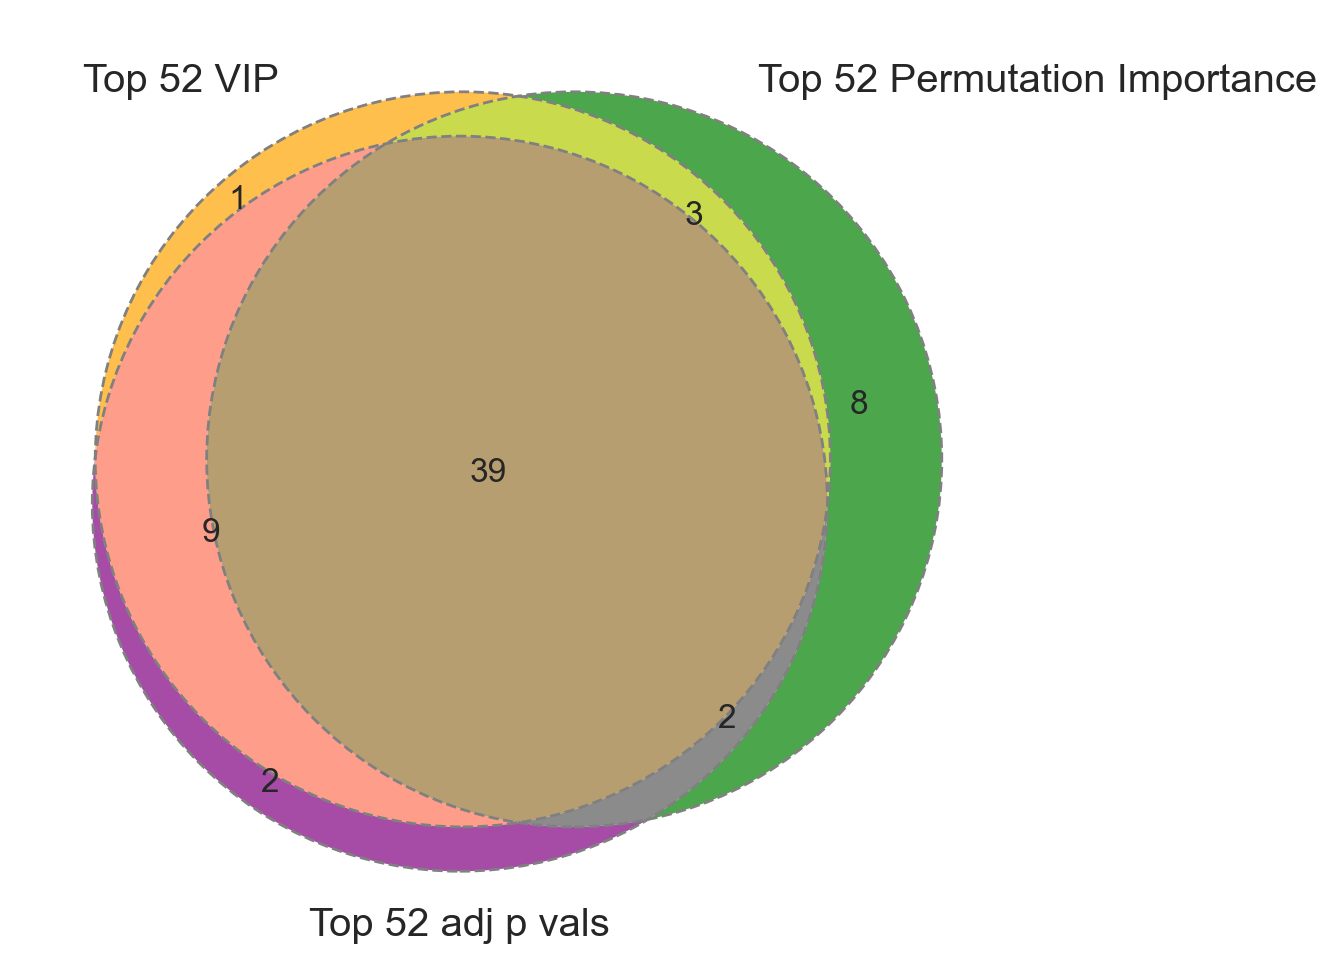

In [95]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles

VIP = set(top52vips['index'].tolist())

PI = set(top52_PI)

Pval = set(top52_sigprot.columns.tolist())

venn3([VIP, PI, Pval], ('Top 52 VIP', 'Top 52 Permutation Importance', 'Top 52 adj p vals'),
      set_colors=("orange", "green", "purple"), alpha=0.7)
venn3_circles([VIP, PI, Pval], linestyle='dashed', linewidth=1, color="grey")
#plt.savefig('Fig4A.svg', bbox_inches='tight')
plt.show()

In [96]:
myset=set(top52vips['index'].tolist() + top52_PI + top52_sigprot.columns.tolist())

In [97]:
len(myset)

64

In [100]:
log_fc=[]
for x in myset:
    log_fc.append(comb_vol[(comb_vol['index']==x)].logFC.item())

In [105]:
genes=[]
prot_name=[]
mean_diff=[]
for x in myset:
    genes+=prot[x].iloc[[2]].to_list()
    prot_name+=prot[x].iloc[[1]].to_list()
    log_fc.append(comb_vol[(comb_vol['index']==x)].logFC.item())
    mean_diff.append(comb_vol[(comb_vol['index']==x)].meand_diff.item())

In [106]:
df_64=pd.DataFrame(list(zip(myset,prot_name,genes, log_fc, mean_diff)),columns=['CluGO Protein','Protein Name','Gene Name','LogFC','Group Mean Diff'])

In [107]:
df_64=df_64.set_index('CluGO Protein')

In [109]:
df_64.to_excel("SuppT2_v2.xlsx")  

In [212]:
with open('VIPSigPIunique.txt', 'w') as f:
    for line in myset:
        f.write(f"{line}\n")

In [213]:
prot_all=prot_bcorr.merge(meta_prot.Group, left_index=True, right_index=True)

In [241]:
df_7sel=prot_all[['P02042','O75882','O00187', 'P00746','A0A075B6I9','A0A075B6H7','P00736','Group']]

In [242]:
df_7sel.Group.value_counts()

0    75
1    62
2    28
3    24
4    13
Name: Group, dtype: int64

In [243]:
df_7sel[['Group']] = df_7sel[['Group']].replace([0], ['Disease'])
df_7sel[['Group']] = df_7sel[['Group']].replace([1], ['Disease'])
df_7sel[['Group']] = df_7sel[['Group']].replace([4], ['Disease'])
df_7sel[['Group']] = df_7sel[['Group']].replace([2], ['Control'])
df_7sel[['Group']] = df_7sel[['Group']].replace([3], ['Control'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [244]:
df_7sel.Group.value_counts()

Disease    150
Control     52
Name: Group, dtype: int64

In [247]:
df_7sel_melt=pd.melt(df_7sel, id_vars=['Group'], value_vars=df_7sel.columns.tolist())

In [224]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(8,9)},font_scale=1.8)

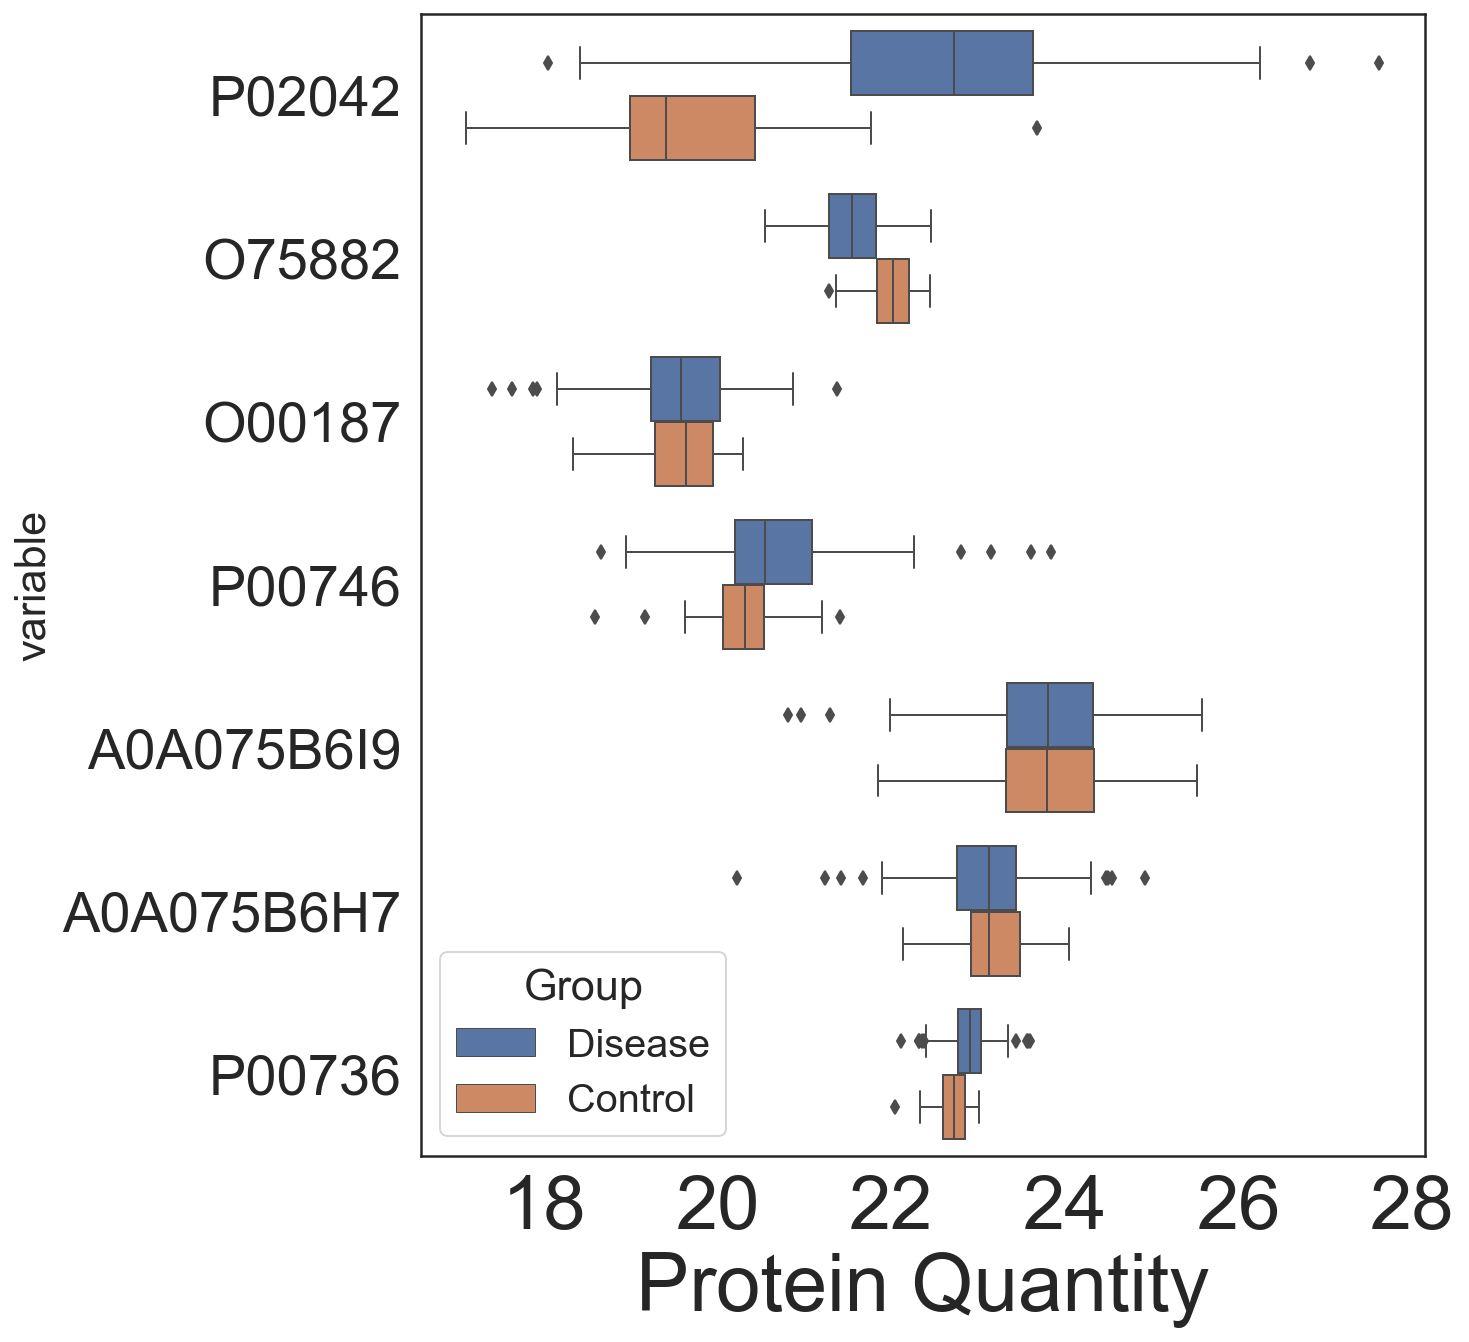

In [249]:
sns.boxplot(data=df_7sel_melt, x='value', y='variable', hue='Group', linewidth=1)
#sns.stripplot(data=df_7sel_melt, x='value', y='variable', hue='Group', dodge=True)

pyplot.xlabel('Protein Quantity', fontsize=40)
plt.xticks(fontsize=38)
plt.yticks(fontsize=28)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 10.5)

#plt.savefig('Fig3E.svg',bbox_inches='tight')
pyplot.show()